# Simulation 

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy import stats
import os, sys                                         
from os.path import dirname as parent_folde
import pandas as pd

In [29]:
# Set som plotting standards:

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)


save_plots = False

In [108]:
Val = [1, 10, 100]         # Different values of noise

Safile_Gil = []
EndClick = []

for test in range(3):

    print(test)

    RT = 0                 # Current time 
    Tmax = 287 + 100 #2000            # Maximum time 

    
    # Different constants for keeping track of the rescaling of the parameters
    vi = 0.01*Val[test]       # vi takes a different value for each test 
    Vol = vi*10**(-14)        # Approximate standard volume for cell nuclei   
    NA = 6.02*10**(23)        # Avogadro's number 
    Cal = NA*Vol*10**(-6)

    
    # X is an array with values being updated in the simulation. X is the values of p53, RNA, mdm2.
    # The initial values will be different for each test
    X = np.zeros(3);   X+= [2095. , 3011., 13012.];    X = X*vi   
    
    X[0] = int(X[0])
    X[1] = int(X[1])
    X[2] = int(X[2])

    TC = 5 # 0.158

    
    # The following parameters are the ones presented in the equations for the model of the system: 
    # They stay constant though each test run.
    kc1 = 0.15*Cal*TC;

    kc2 = 0.1*TC;

    kc3 = 0.1*Cal;

    kc4 = 0.1/Cal*TC;

    kc5 = 0.1*TC

    kc6 = 0.2*TC

    kc7 = 0.1*TC

    
    # Creating matrix with six rows and three columns and setting entries:
    # S is used for updating X (p53, mdm2, RNA(mdm2))
    S = np.zeros((6,3))   
    S[0,0] = 1; S[1,0] = -1; S[2,1] = 1; S[3,1] = -1; S[4,2] = 1; S[5,2] = -1

    
    # ts is the time step and click fills out every entry in the Safile matrix 
    ts = 1; 
    click = 0;
    
    
    # Creating array with each term in the equations for the system, i.e. the current rates 
    R = np.zeros(6)
    
    # Matrix for saving simulation data: 
    Safile1 = np.zeros((int(Tmax/ts+10), 4))

    
    # Running the loop as long as the current time is smaller than the maximum time value
    # In the loop the current rates are calculated using the current values of p53, RNA, mdm2
    while RT < Tmax: 

        Ar = np.random.random()    # Generating a random float in the interval [0, 1[

        R[0] = kc1                          

        R[1] = kc2*X[2]*X[0]/(X[0]+kc3)    

        R[2] = kc4*X[0]*(X[0]-1)           

        R[3] = kc5*X[1]

        R[4] = kc6*X[1]

        R[5] = kc7*X[2]

        Rtot = np.sum(R)         # The total rate 

        # Finding the next time step(time until next event), which is random due to Ar and scaled by the total rate 
        # That is updating the time by this amount
        RT -= np.log(Ar)/Rtot    # log(Ar) is a negative number 

    
        Ar = np.random.random()  # Generating another random float in the interval [0, 1[
        Cr = 0
        ct = 0

        
        # As long as the value Cr is smaller than the random number Ar
        # That is finding the smallest event that makes the total rates(until that event) become larger than Ar
        while Cr < Ar:  

            Cr += R[ct]/Rtot  # Cr increases by this amount 

            if (Cr < Ar):  # If it is still smaller, move on to the next rate 

                ct += 1

    
        # Updating X according to the row number ct, which is the rate that makes Cr bigger than Ar
        # That is updating X according to the event 
        X += S[ct,:] 
        

    
        # As long as the current time is larger than the timestep times the click, the values get filled in Safile
        # The values are constant until the next event arises. 
        while (RT > ts*click):  
            
            Safile1[click,0] = RT   # The 0'th column is the time 
            
            Safile1[click,1] = X[0]  # p53 
            
            Safile1[click,2] = X[1]  # RNA
            
            Safile1[click,3] = X[2]  # mdm2
            
            click+=1
            
    EndClick.append(click)
    Safile_Gil.append(Safile1)

0
1
2


In [109]:
# Euler deterministic simulation. Euler and Gillespie should converge towards each other, when the noise is small. 
ys = Safile1[100:EndClick[-1],1]/Cal;

ti = Safile1[100:EndClick[-1],0];

X = np.zeros(3);    X+=[2095. , 3011., 13012.];    X = X*vi   # From the last run vi = 1. No noise. 

X[0] = int(X[0]) 
X[1] = int(X[1])
X[2] = int(X[2])

RT = 0; click = 0; 

Safile_Euler = np.zeros((int(Tmax/ts+1),4))

dX = np.zeros(3); dt = 0.1;



while RT < Tmax:

    dX[0] = kc1 - kc2*X[2]*X[0]/(X[0]+kc3);

    dX[1] = kc4*X[0]*(X[0]-1) -  kc5*X[1];

    dX[2] = kc6*X[1] - kc7*X[2];

    RT += dt;

    X += dX*dt   # Finding the new values of p53, RNA, mdm2

    
    if (RT > ts*click):        

        Safile_Euler[click,0] = RT

        Safile_Euler[click,1] = X[0]

        Safile_Euler[click,2] = X[1]

        Safile_Euler[click,3] = X[2]

        click+=1

In [110]:
# Applying a 4'th order polynomial filter to get the oscillations around zero: 

import warnings
warnings.simplefilter('ignore', np.RankWarning)

resi_m = []
resi_p = []

for i in range(len(Safile_Gil)):
    
    coef_p = np.polyfit(Safile_Gil[i][100:EndClick[i], 0], Safile_Gil[i][100:EndClick[i], 1], 4)
    coef_m = np.polyfit(Safile_Gil[i][100:EndClick[i], 0], Safile_Gil[i][100:EndClick[i], 3], 4)
    
    resi_p.append(Safile_Gil[i][100:EndClick[i], 1] - np.polyval(coef_p[:], Safile_Gil[i][100:EndClick[i], 0]))
    resi_m.append(Safile_Gil[i][100:EndClick[i], 3] - np.polyval(coef_m[:], Safile_Gil[i][100:EndClick[i], 0]))

In [112]:
roll_resi_m = [np.roll(resi_m[i], -3) for i in range(len(resi_m))]

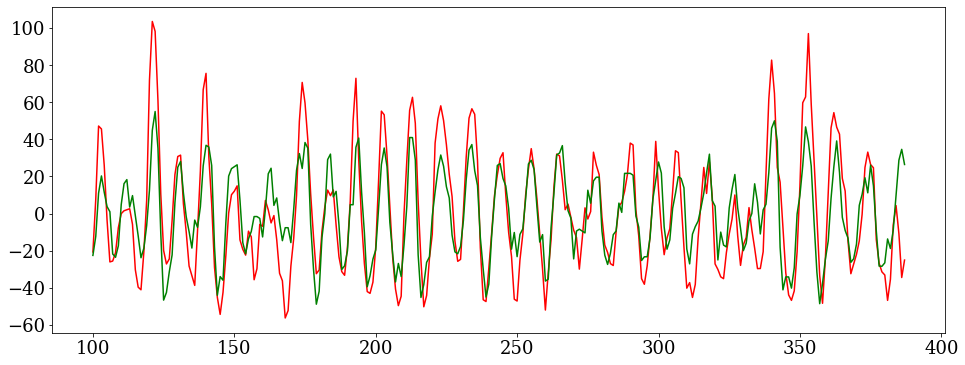

In [116]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(Safile_Gil[0][100:EndClick[0], 0], roll_resi_m[0], color='red', label='mdm2')
ax.plot(Safile_Gil[0][100:EndClick[0], 0], resi_p[0], color='green', label='p53');

[Text(0, 0.5, 'Concentration'),
 Text(0.5, 0, 'Time'),
 Text(0.5, 1.0, 'Simulation of p53-mdm2-circuit')]

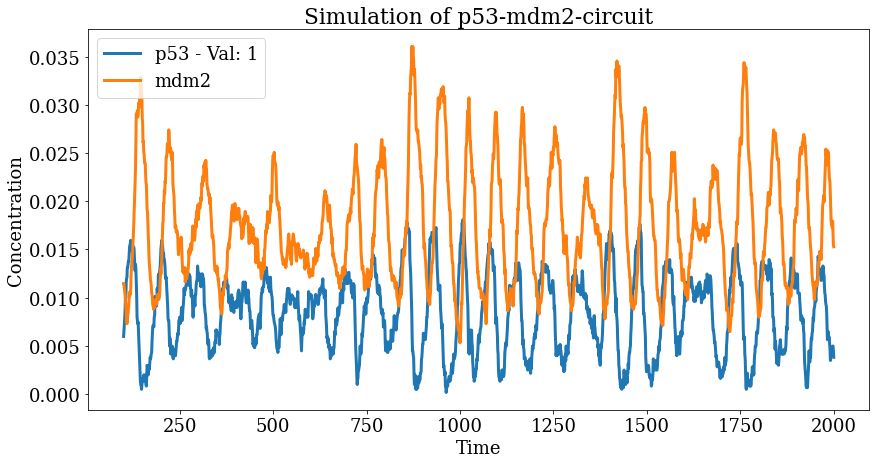

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,7))
    
ax.plot(Safile_Gil[0][100:EndClick[0],0], Safile_Gil[0][100:EndClick[0],1]/Cal,lw=3, label=f'p53 - Val: {Val[0]}')
ax.plot(Safile_Gil[0][100:EndClick[0],0], Safile_Gil[0][100:EndClick[0],3]/Cal,lw=3, label=f'mdm2')


#ax.plot(Safile[100:,0],Safile[100:,1]/Cal,'--k',lw=1)
ax.legend()
ax.set(xlabel='Time', 
       ylabel='Concentration',
       title='Simulation of p53-mdm2-circuit')

[Text(0, 0.5, 'Concentration'),
 Text(0.5, 0, 'Time'),
 Text(0.5, 1.0, 'Simulation of p53-mdm2-circuit')]

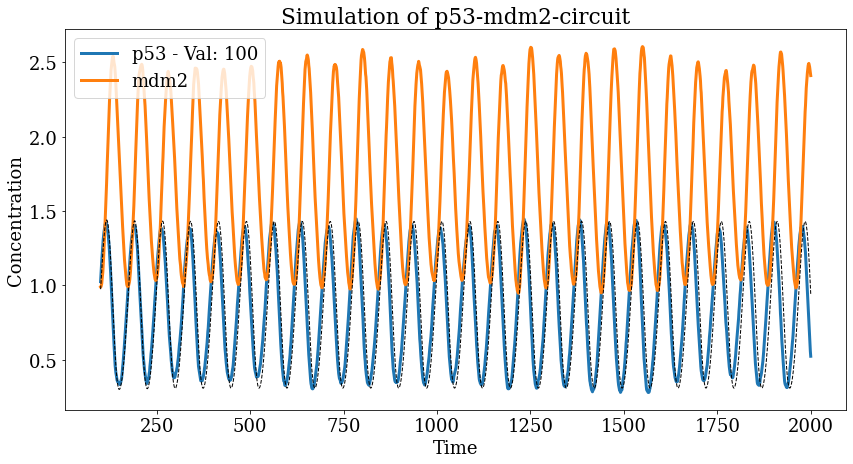

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,7))
    
ax.plot(Safile_Gil[2][100:EndClick[2],0], Safile_Gil[2][100:EndClick[2],1]/Cal,lw=3, label=f'p53 - Val: {Val[2]}')
ax.plot(Safile_Gil[2][100:EndClick[2],0], Safile_Gil[2][100:EndClick[2],3]/Cal,lw=3, label=f'mdm2')


ax.plot(Safile_Euler[100:EndClick[2],0],Safile_Euler[100:EndClick[2],1]/Cal,'--k',lw=1)
ax.legend()
ax.set(xlabel='Time', 
       ylabel='Concentration',
       title='Simulation of p53-mdm2-circuit')